<a href="https://colab.research.google.com/github/voirinprof/python-geo-colab/blob/main/Classification_non_supervis%C3%A9e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutoriel : Classification non supervisée avec Google Earth Engine et Google Colab


### Objectif

1. Configurer notre environnement.
2. Charger une image satellite avec GEE.
3. Analyser une image et classifier son contenu.
4. Visualiser les résultats sur une carte interactive.


Prérequis : Un compte Google (pour Colab, GEE et Google Drive).

## Installer GEE dans Colab

In [1]:
# Installer et configurer GEE
!pip install earthengine-api  # Installe l'API GEE

## Importer les libs utiles

In [2]:
import ee  # Importe la bibliothèque GEE
import geemap  # Pour afficher des cartes interactives

# Authentification (exécutez cette cellule et suivez les instructions)
ee.Authenticate()  # Ouvre une fenêtre pour se connecter à votre compte Google
ee.Initialize(project="gmq580")  # Initialise GEE avec vos identifiants

# il peut être nécessaire de créer un projet dans Google Cloud Console

print("GEE est prêt à être utilisé !")

GEE est prêt à être utilisé !


## Débuter votre analyse

Définir une zone d’intérêt

In [3]:
# On va utiliser la localisation de Sherbrooke
region = ee.Geometry.Point([-71.888351, 45.404476])  # Centre sur Sherbrooke
area = region.buffer(10000)  # Crée une zone tampon de 10 km autour du point

Charger des données satellites

In [5]:
# Charger une collection Sentinel-2 (images satellites)
# on limite à notre zone d'étude
# on limite une période temporelle
# on souhaite les images avec peu de nuages

# de plus, on va combiner les images en une seule image (médiane des images)
sentinel = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterBounds(area) \
            .filterDate('2024-06-01', '2024-08-31') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .median()

# Sélectionner les bandes spectrales et calculer le NDVI
bands = sentinel.select(['B2', 'B3', 'B4', 'B8'])  # Bleu, Vert, Rouge, NIR
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')
image = bands.addBands(ndvi)  # Combiner les bandes et le NDVI

Effectuer la classification non supervisée

In [6]:
# Définir les paramètres de l'entraînement
training = image.sample(
    region=area,
    scale=10,  # Résolution de 10 m
    numPixels=5000  # Nombre d'échantillons pour l'entraînement
)

# Créer et entraîner le classificateur K-Means
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=7,  # Nombre de clusters
    seed=42  # Pour la reproductibilité
).train(training)

# Appliquer le classificateur à l'image
classified = image.cluster(clusterer)

Visualiser les résultats

In [8]:
# Créer une carte interactive avec geemap
Map = geemap.Map(center=[45.404476, -71.888351], zoom=11)

# Ajouter l'image RGB pour référence
rgb_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(sentinel, rgb_params, 'Image RGB')

# Ajouter la classification
cluster_params = {'min': 0, 'max': 6, 'palette': ['red', 'yellow', 'green', 'blue', 'purple', 'orange', 'brown']}
Map.addLayer(classified, cluster_params, 'Clusters K-Means')

# Afficher la carte
Map.addLayerControl()  # Ajouter un contrôle des couches
Map

Map(center=[45.404476, -71.888351], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

Calculer les statistiques par cluster

In [9]:
import pandas as pd

# Calculer le nombre de pixels et la superficie par cluster
pixel_count = classified.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=area,
    scale=10,
    maxPixels=1e9
)

# Récupérer l'histogramme des clusters
histogram = ee.Dictionary(pixel_count.get('cluster')).getInfo()

# Calculer la superficie (pixel de 10 m x 10 m = 100 m²)
pixel_area = 100  # m² par pixel
stats = {
    'Cluster': [],
    'Nb_Pixels': [],
    'Superficie_m2': [],
    'Superficie_km2': []
}

for cluster, count in histogram.items():
    stats['Cluster'].append(int(cluster))
    stats['Nb_Pixels'].append(count)
    superficie_m2 = count * pixel_area
    stats['Superficie_m2'].append(superficie_m2)
    stats['Superficie_km2'].append(superficie_m2 / 1e6)  # Conversion en km²

# Convertir en DataFrame
df_stats = pd.DataFrame(stats)

# Calculer les statistiques du NDVI par cluster
ndvi_per_cluster = ndvi.addBands(classified).reduceRegion(
    reducer=ee.Reducer.mean().group(groupField=1),  # Grouper par cluster
    geometry=area,
    scale=10,
    maxPixels=1e9
)

# Extraire les moyennes NDVI par cluster
ndvi_groups = ee.List(ndvi_per_cluster.get('groups')).getInfo()
ndvi_means = {group['group']: group['mean'] for group in ndvi_groups}
df_stats['NDVI_Moyen'] = df_stats['Cluster'].map(lambda x: ndvi_means.get(x, 0))

# Afficher le tableau
print("Statistiques par cluster :")
print(df_stats)

Statistiques par cluster :
   Cluster     Nb_Pixels  Superficie_m2  Superficie_km2  NDVI_Moyen
0        0  4.937040e+05   4.937040e+07       49.370405    0.376106
1        1  5.911783e+05   5.911783e+07       59.117832    0.793819
2        2  4.357880e+05   4.357880e+07       43.578796    0.655627
3        3  3.558616e+05   3.558616e+07       35.586159    0.119367
4        4  1.162934e+06   1.162934e+08      116.293371    0.751323
5        5  8.961409e+05   8.961409e+07       89.614089    0.730595
6        6  4.954142e+05   4.954142e+07       49.541420    0.579529


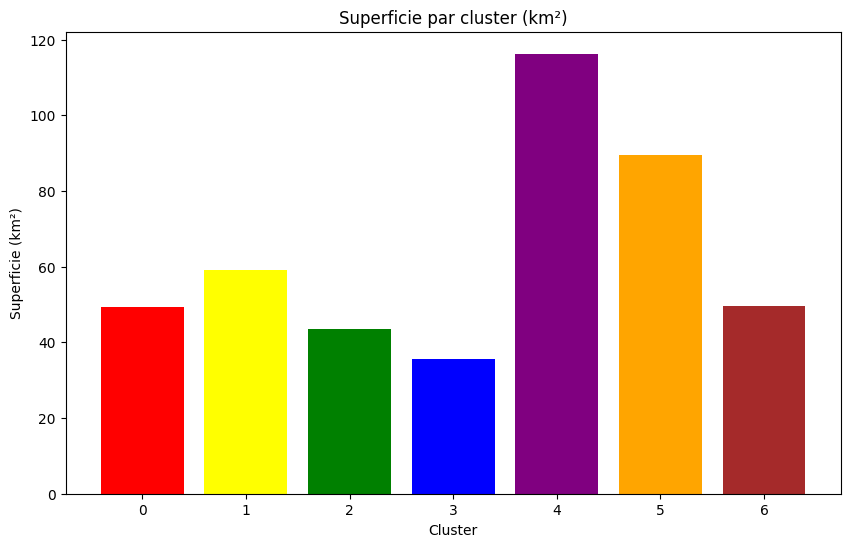

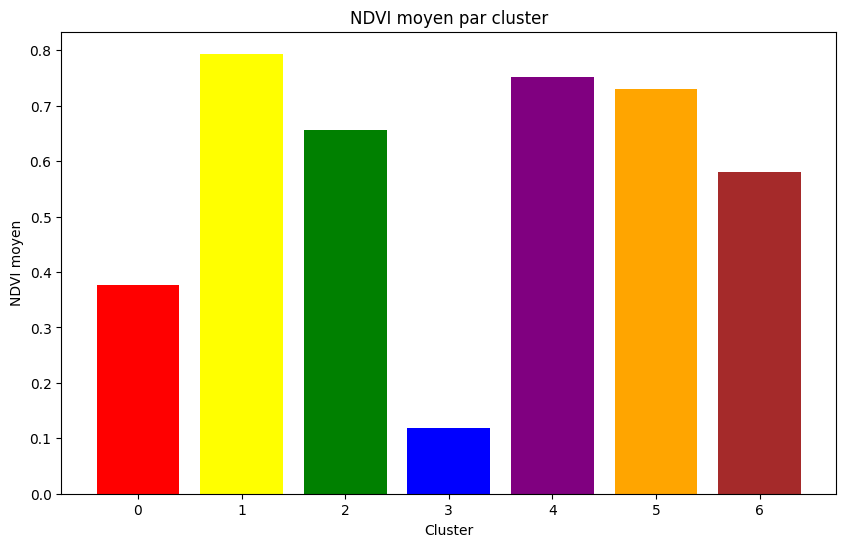

In [11]:
import matplotlib.pyplot as plt

# Graphique : Superficie par cluster
plt.figure(figsize=(10, 6))
plt.bar(df_stats['Cluster'], df_stats['Superficie_km2'], color=['red', 'yellow', 'green', 'blue', 'purple', 'orange', 'brown'])
plt.title('Superficie par cluster (km²)')
plt.xlabel('Cluster')
plt.ylabel('Superficie (km²)')
plt.show()

# Graphique : NDVI moyen par cluster
plt.figure(figsize=(10, 6))
plt.bar(df_stats['Cluster'], df_stats['NDVI_Moyen'], color=['red', 'yellow', 'green', 'blue', 'purple', 'orange', 'brown'])
plt.title('NDVI moyen par cluster')
plt.xlabel('Cluster')
plt.ylabel('NDVI moyen')
plt.show()